# Please note: none of the parameters for these above classifiers are optimized

In [1]:
# reference : https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb/code 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline



df_train = pd.read_csv('../data/train.csv')
#df_test = pd.read_csv('../data/test.csv')

In [2]:
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


Total number of question pairs for training: 404290
Duplicate pairs: 36.92%
Total number of questions in the training data: 537933
Number of questions that appear multiple times: 111780



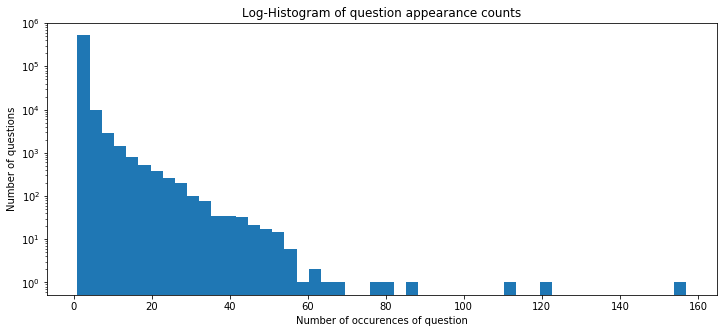

In [3]:
print('Total number of question pairs for training: {}'.format(len(df_train)))
print('Duplicate pairs: {}%'.format(round(df_train['is_duplicate'].mean()*100, 2)))
qids = pd.Series(df_train['qid1'].tolist() + df_train['qid2'].tolist())
print('Total number of questions in the training data: {}'.format(len(
    np.unique(qids))))
print('Number of questions that appear multiple times: {}'.format(np.sum(qids.value_counts() > 1)))

plt.figure(figsize=(12, 5))
plt.hist(qids.value_counts(), bins=50)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
print()

In [4]:
from sklearn.metrics import log_loss

# sklearn.metrics.log_loss(y_true, y_pred, eps=1e-15, normalize=True, sample_weight=None, labels=None)
# This is the loss function used in (multinomial) logistic regression and extensions of it such
# as neural networks, defined as the negative log-likelihood of the true labels given a probabilistic 
# classifier’s predictions. The log loss is only defined for two or more labels. 
# For a single sample with true label yt in {0,1} and estimated probability yp that yt = 1, the log loss is
# -log P(yt|yp) = -(yt log(yp) + (1 - yt) log(1 - yp))

# numpy.zeros_like(a, dtype=None, order='K', subok=True)
#   Return an array of zeros with the same shape and type as a given array.

p = df_train['is_duplicate'].mean() # Our predicted probability
print(p)
print('Predicted score:', log_loss(df_train['is_duplicate'], np.zeros_like(df_train['is_duplicate']) + p))


df_test = pd.read_csv('../data/test.csv')
sub = pd.DataFrame({'test_id': df_test['test_id'], 'is_duplicate': p})
sub.to_csv('naive_submission.csv', index=False)
sub.head()


0.369197853026293
Predicted score: 0.658527383984


,is_duplicate,test_id
0,0.369198,0
1,0.369198,1
2,0.369198,2
3,0.369198,3
4,0.369198,4


(-0.5, 1439.5, 1079.5, -0.5)

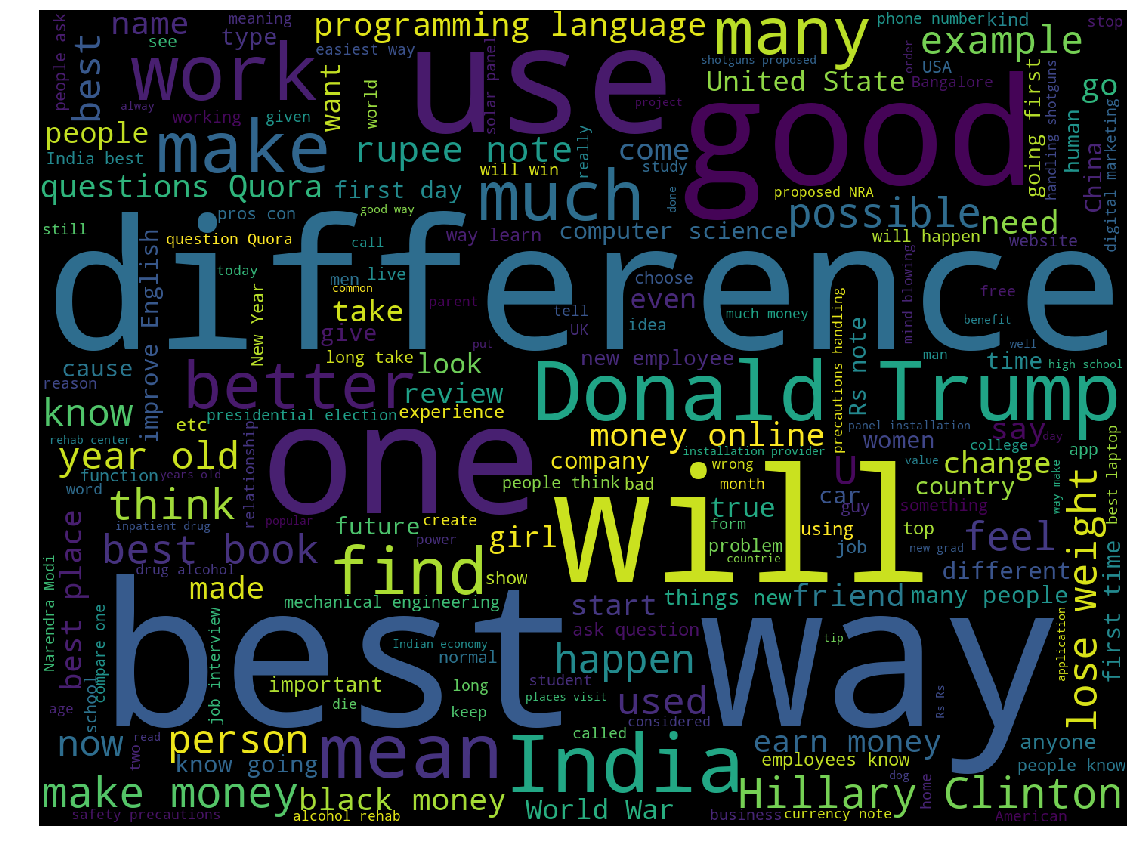

In [5]:
# astype - Copy of the array, cast to a specified type.
# panda.series - creates index for every data.
train_qs = pd.Series(df_train['question1'].tolist() + df_train['question2'].tolist()).astype(str)

from wordcloud import WordCloud
cloud = WordCloud(width=1440, height=1080).generate(" ".join(train_qs.astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')


In [6]:
qmarks = np.mean(train_qs.apply(lambda x: '?' in x))
math = np.mean(train_qs.apply(lambda x: '[math]' in x))
fullstop = np.mean(train_qs.apply(lambda x: '.' in x))
capital_first = np.mean(train_qs.apply(lambda x: x[0].isupper()))
capitals = np.mean(train_qs.apply(lambda x: max([y.isupper() for y in x])))
numbers = np.mean(train_qs.apply(lambda x: max([y.isdigit() for y in x])))

print('Questions with question marks: {:.2f}%'.format(qmarks * 100))
print('Questions with [math] tags: {:.2f}%'.format(math * 100))
print('Questions with full stops: {:.2f}%'.format(fullstop * 100))
print('Questions with capitalised first letters: {:.2f}%'.format(capital_first * 100))
print('Questions with capital letters: {:.2f}%'.format(capitals * 100))
print('Questions with numbers: {:.2f}%'.format(numbers * 100))


Questions with question marks: 99.87%
Questions with [math] tags: 0.12%
Questions with full stops: 6.31%
Questions with capitalised first letters: 99.81%
Questions with capital letters: 99.95%
Questions with numbers: 11.83%


Text(0.5,0,'word_match_share')

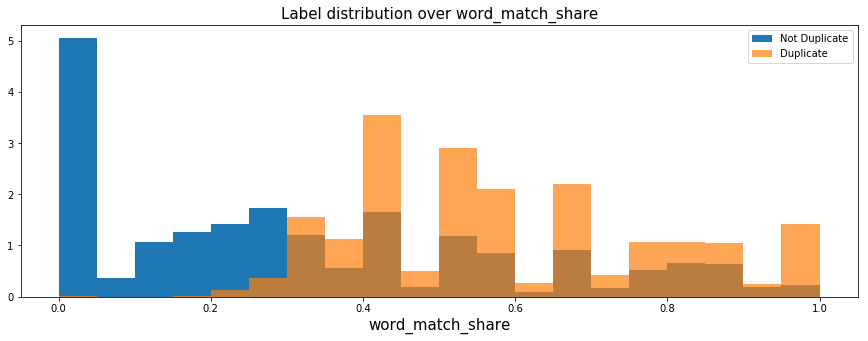

In [7]:

from nltk.corpus import stopwords

stops = set(stopwords.words("english"))

def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    #import pdb; pdb.set_trace()
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    #print(shared_words_in_q1)
    #print(shared_words_in_q2)
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

plt.figure(figsize=(15, 5))
train_word_match = df_train.apply(word_match_share, axis=1, raw=True)
plt.hist(train_word_match[df_train['is_duplicate'] == 0], bins=20, normed=True, label='Not Duplicate')
plt.hist(train_word_match[df_train['is_duplicate'] == 1], bins=20, normed=True, alpha=0.7, label='Duplicate') #alpha to make it transparenr
plt.legend()
plt.title('Label distribution over word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)


In [8]:
from collections import Counter

# If a word appears only once, we ignore it completely (likely a typo)
# Epsilon defines a smoothing constant, which makes the effect of extremely rare words smaller
def get_weight(count, eps=10000, min_count=2):
    if count < min_count:
        return 0
    else:
        return 1 / (count + eps)

eps = 5000 
words = (" ".join(train_qs)).lower().split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


Text(0.5,0,'word_match_share')

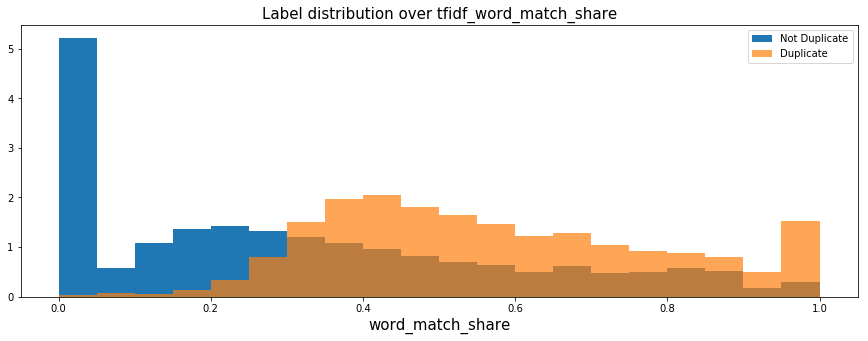

In [9]:
def tfidf_word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    
    shared_weights = [weights.get(w, 0) for w in q1words.keys() if w in q2words] + [weights.get(w, 0) for w in q2words.keys() if w in q1words]
    total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]
    
    R = np.sum(shared_weights) / np.sum(total_weights)
    return R

plt.figure(figsize=(15, 5))
tfidf_train_word_match = df_train.apply(tfidf_word_match_share, axis=1, raw=True)
plt.hist(tfidf_train_word_match[df_train['is_duplicate'] == 0].fillna(0), bins=20, normed=True, label='Not Duplicate')
plt.hist(tfidf_train_word_match[df_train['is_duplicate'] == 1].fillna(0), bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over tfidf_word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

In [10]:
from sklearn.metrics import roc_auc_score
print('Original AUC:', roc_auc_score(df_train['is_duplicate'], train_word_match))
print('   TFIDF AUC:', roc_auc_score(df_train['is_duplicate'], tfidf_train_word_match.fillna(0)))

Original AUC: 0.780432704935
   TFIDF AUC: 0.770480229222


In [163]:
# First we create our training and testing data
x_train = pd.DataFrame() # creates empty dataframe!
x_test = pd.DataFrame()
#import pdb; pdb.set_trace()
x_train['word_match'] = train_word_match
x_train['tfidf_word_match'] = tfidf_train_word_match
x_test['word_match'] = df_test.apply(word_match_share, axis=1, raw=True)
#import pdb; pdb.set_trace()
x_test['tfidf_word_match'] = df_test.apply(tfidf_word_match_share, axis=1, raw=True)

y_train = df_train['is_duplicate'].values

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in long_scalars


In [164]:
pos_train = x_train[y_train == 1]
neg_train = x_train[y_train == 0]

# Now we oversample the negative class
# There is likely a much more elegant way to do this...
p = 0.165
scale = ((len(pos_train) / (len(pos_train) + len(neg_train))) / p) - 1
while scale > 1:
    neg_train = pd.concat([neg_train, neg_train])
    scale -=1
neg_train = pd.concat([neg_train, neg_train[:int(scale * len(neg_train))]])
print(len(pos_train) / (len(pos_train) + len(neg_train)))

x_train = pd.concat([pos_train, neg_train])
y_train = (np.zeros(len(pos_train)) + 1).tolist() + np.zeros(len(neg_train)).tolist()
del pos_train, neg_train

0.19124366100096607


In [165]:
#Finally, we split some of the data off for validation
from sklearn.cross_validation import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=4242)


In [37]:
len(x_train)

127874

In [38]:
len(x_valid)

31969

In [40]:
# xgboost copied from the link described on top on this notebook. Later below, I am using a different appoarch 
import xgboost as xgb

# Set our parameters for xgboost
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=10)

[0]	train-logloss:0.683216	valid-logloss:0.683119
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.602274	valid-logloss:0.60135
[20]	train-logloss:0.545238	valid-logloss:0.543682
[30]	train-logloss:0.503634	valid-logloss:0.501614
[40]	train-logloss:0.472548	valid-logloss:0.470158
[50]	train-logloss:0.448945	valid-logloss:0.446251
[60]	train-logloss:0.430798	valid-logloss:0.427865
[70]	train-logloss:0.416681	valid-logloss:0.413546
[80]	train-logloss:0.405637	valid-logloss:0.402388
[90]	train-logloss:0.396938	valid-logloss:0.393622
[100]	train-logloss:0.390048	valid-logloss:0.386721
[110]	train-logloss:0.384612	valid-logloss:0.381296
[120]	train-logloss:0.380317	valid-logloss:0.376951
[130]	train-logloss:0.376907	valid-logloss:0.373549
[140]	train-logloss:0.374193	valid-logloss:0.37088
[150]	train-logloss:0.372006	valid-logloss:0.368716
[160]	train-logloss:0.370236	v

# Remember, we are using two features of input 
1. word_match
2. tfidf
So for every input of training set, x has dimension of 2.

X (2,m) and Y (1,m) where m is size of training set.

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Logistic Regression

In [188]:
# Logistic Regression 

log_clf = LogisticRegression(random_state=42)

# pd.isnull(x_train).any(1).nonzero()[0] - this can be used to find indexs of NaN rows
# x_train.iloc[[121201]] # to read a particular row of dataframe.
x_train = x_train.fillna(0) #fill NaN with 0.0
x_train = x_train.replace(np.inf, 0.0) # replace inf with 0.0

log_clf.fit(x_train, y_train)

x_valid = x_valid.fillna(0) #fill NaN with 0.0
x_valid = x_valid.replace(np.inf, 0.0) # replace inf with 0.0
y_pred = log_clf.predict(x_valid)
from sklearn.metrics import accuracy_score

print(accuracy_score(y_valid, y_pred))

from sklearn.metrics import log_loss

print(log_loss(y_valid,y_pred))

0.792104959705
7.18046980006


# Doubt: Why is logloss high? y_pred is either 0 or 1. not a soft value.

In [139]:
'''
df_test = pd.read_csv('../data/test.csv')
sub = pd.DataFrame({'test_id': df_test['test_id'], 'is_duplicate': p})
sub.to_csv('naive_submission.csv', index=False)
sub.head()
'''

,is_duplicate,test_id
0,0.165,0
1,0.165,1
2,0.165,2
3,0.165,3
4,0.165,4


In [147]:
[i for i in y_valid if i > 1.0]

[]

# Simple Decision Tree Classifier

In [151]:
# Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(x_train, y_train)
y_pred_tree = tree_clf.predict(x_valid)
print(accuracy_score(y_valid, y_pred_tree))
print(log_loss(y_valid,y_pred_tree))

0.792955675811
7.1511402805


# Desicion Tree with Bagging. (max_samples = 100)

In [153]:
# Bagging Classifier
from sklearn.ensemble import BaggingClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=42)
bag_clf.fit(x_train, y_train)
y_pred_bagdtc = bag_clf.predict(x_valid)
print(accuracy_score(y_valid, y_pred_bagdtc))
print(log_loss(y_valid,y_pred_bagdtc))

0.817072789265
6.31808920648


# Random Forest.


In [154]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(x_train, y_train)

y_pred_rf = rnd_clf.predict(x_valid)
print(accuracy_score(y_valid, y_pred_rf))
print(log_loss(y_valid,y_pred_rf))

0.817260471081
6.31160688116


# Adaboost Classifer

In [159]:
#Adaboost classifier
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(x_train, y_train)
y_pred_ada = ada_clf.predict(x_valid)
print(accuracy_score(y_valid, y_pred_ada))
print(log_loss(y_valid,y_pred_ada))

0.81735431199
6.30836608118


# Gradient Boost Classifier

In [189]:
# Gradient Boost classifier
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor


#X_train, X_val, y_train, y_val = train_test_split(x_train, y_train, random_state=49)
x_train = x_train.fillna(0) #fill NaN with 0.0
x_train = x_train.replace(np.inf, 0.0) # replace inf with 0.0
x_valid = x_valid.fillna(0) #fill NaN with 0.0
x_valid = x_valid.replace(np.inf, 0.0) # replace inf with 0.0
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=150, random_state=42)
gbrt.fit(x_train, y_train)

# This below part of logic tries to find best number of estimators
errors = [mean_squared_error(y_valid, y_pred)
          for y_pred in gbrt.staged_predict(x_valid)]
bst_n_estimators = np.argmin(errors)

gbrt_best = GradientBoostingRegressor(max_depth=2,n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(x_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=119, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

In [193]:
y_pred_gradboost = gbrt_best.predict(x_valid)
#print(accuracy_score(y_valid, y_pred_gradboost))
print(log_loss(y_valid,y_pred_gradboost))

0.365329582807


In [194]:
print(y_pred_gradboost)

[ 0.36463542  0.00302195  0.36315368 ...,  0.35870395  0.00302195
  0.00302195]


In [195]:
print(len(errors))

120


In [196]:
print(bst_n_estimators)

119


# Creating .csv for test data (to be submitted.)

In [186]:
x_test = x_test.fillna(0) #fill NaN with 0.0
x_test = x_test.replace(np.inf, 0.0) # replace inf with 0.0
p_test = gbrt_best.predict(x_test)
sub = pd.DataFrame()
sub['test_id'] = df_test['test_id']
sub['is_duplicate'] = p_test
sub.to_csv('simple_xgb.csv', index=False)

Name
Submitted
Wait time
Execution time
Score
simple_xgb.csv
a few seconds ago
10 seconds
16 seconds
0.35535

# 0.35535 - result.